In [17]:
import numpy as np
import pandas as pd
import re
import glob
import math
from lxml import etree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, auc, roc_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch

def load_xml_files(directory):
    """Load and parse XML files into a DataFrame."""
    xml_list = glob.glob(f"{directory}/*.xml")
    parser = etree.XMLParser(recover=True)
    dfs = []

    for ii in xml_list:
        with open(ii, 'rb') as file:
            xml_data = file.read()
            dfs.append(xml2df(xml_data, parser))
    
    data = pd.concat(dfs)
    return data.drop_duplicates().sort_values("startDateTime")

def xml2df(xml_data, parser):
    """Convert XML data to pandas DataFrame."""
    root = etree.fromstring(xml_data, parser=parser)
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
        all_records.append(record)
    return pd.DataFrame(all_records)

def preprocess_data(data):
    """Preprocess data by creating IP dyads and calculating bytes."""
    data['totalBytes'] = data['totalSourceBytes'].astype(float) + data['totalDestinationBytes'].astype(float)
    data['seqId'] = data['lowIP'] + '_' + data['highIP']  + '_' + data['startDateTime'].str[:13]
    data['protoBytes'] = data[['protocolName','totalBytes']].apply(
        lambda x: str(x[0])[0] + str(math.floor(np.log2(x[1] + 1.0))), axis=1)
    return data

def create_sequences(data, seq_len=10):
    """Generate sequences for modeling."""
    key = data.groupby('seqId')[['Tag','protoBytes']].agg({
        "Tag":lambda x: "%s" % ','.join([a for a in x]),
        "protoBytes":lambda x: "%s" % ','.join([str(a) for a in x])
    })

    attacks = [a.split(",") for a in key['Tag'].tolist()]
    sequences = [a.split(",") for a in key['protoBytes'].tolist()]

    # Normalization of tokens
    unique_tokens = list(set([a for b in sequences for a in b]))
    le = LabelEncoder()
    le.fit(unique_tokens)
    encoded_tokens = le.transform(unique_tokens)

    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_tokens = scaler.fit_transform(encoded_tokens.reshape(-1, 1)).flatten()
    token_to_normalized = dict(zip(le.classes_, normalized_tokens))
    sequences = [[token_to_normalized[token] for token in seq] for seq in sequences]

    # Convert text tags into integers
    for i in range(len(attacks)):
        attacks[i] = [1 if tag == 'Attack' else 0 for tag in attacks[i]]

    sequence_attack = zip(attacks, sequences)
    return create_model_sequences(sequence_attack, seq_len)

def create_model_sequences(sequence_attack, seq_len):
    """Prepare sequences for the model."""
    seq_x, seq_y, seq_index, seq_attack = [], [], [], []
    for si, (sa, ss) in enumerate(sequence_attack):
        prepend = [0.] * seq_len
        seq = prepend + ss
        seqa = prepend + sa
        for ii in range(seq_len, len(seq)):
            subseq = seq[(ii-seq_len+1):(ii+1)]
            subseqa = seqa[(ii-seq_len+1):(ii+1)]
            is_anomaly = int(any(subseqa))
            seq_x.append(subseq)
            seq_y.append(is_anomaly)
            seq_index.append(si)
            seq_attack.append(seqa[ii])

    frame = pd.DataFrame(seq_x)
    frame = pd.concat([frame, pd.DataFrame(seq_y)], axis=1)
    return frame, seq_x, seq_y, seq_index, seq_attack

# Load and process data
print("Loading data...")
data_directory = r"D:\AML\ISCX dataset\transformer"
data = load_xml_files(data_directory)
print("De-dup Flows:", len(data))
data = preprocess_data(data)
frame, seq_x, seq_y, seq_index, seq_attack = create_sequences(data)

print("Ready to Go!")

Loading data...
Total Files: 6
De-dup Flows: 925212


C:\Users\Yaphe\AppData\Local\Temp\ipykernel_15892\2947224054.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['lowIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] <= x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_15892\2947224054.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['highIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] > x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_15892\2947224054.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

Ready to Go!


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # pe shape [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x has shape [batch_size, seq_len, d_model]
        # Slice pe to match x's seq_len and expand to batch size
        pe = self.pe[:, :x.size(1), :]  # pe shape [1, seq_len, d_model]
        pe = pe.expand(x.size(0), -1, -1)  # Expand to match batch size: [batch_size, seq_len, d_model]
        x = x + pe
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_encoder_layers=4, dim_feedforward=2048, dropout=0.1, output_dim=2):
        super(TransformerClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, d_model, kernel_size=7, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(d_model)
        self.conv2 = nn.Conv1d(d_model, d_model, kernel_size=7, stride=1, padding='same')
        self.bn2 = nn.BatchNorm1d(d_model)
        # 新增卷积层
        self.conv3 = nn.Conv1d(d_model, d_model, kernel_size=7, stride=1, padding='same')
        self.bn3 = nn.BatchNorm1d(d_model)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=5000)
        # 可以考虑增加Transformer编码器层的数量
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        
        # 新增全连接层
        self.fc = nn.Linear(d_model, d_model)
        
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        x = F.relu(self.bn1(self.conv1(src)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        # 应用新增卷积层
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        
        x = x.permute(2, 0, 1)
        
        x = self.pos_encoder(x * math.sqrt(self.d_model))
        x = self.transformer_encoder(x)
        
        # 应用新增的全连接层
        x = F.relu(self.fc(x[-1, :, :]))
        
        x = self.decoder(x)
        return F.log_softmax(x, dim=1)


In [20]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming 'frame' is a pandas DataFrame with your data

# Split the data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# X = torch.tensor(frame.iloc[:, 0:60].values).float().unsqueeze(1).to(device)
# y = torch.tensor(frame.iloc[:, 60].values).long().to(device)
X = torch.tensor(frame.iloc[:, 0:10].values).float().unsqueeze(1).to(device)
y = torch.tensor(frame.iloc[:, 10].values).long().to(device)

# Create datasets
dataset = TensorDataset(X, y)

# Split into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Using device: cuda:0


In [21]:
criterion = nn.CrossEntropyLoss()
model = TransformerClassifier(input_dim=60, d_model=60, nhead=10, num_encoder_layers=4, dim_feedforward=2048, dropout=0.1, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

c:\Users\Yaphe\anaconda3\envs\dl\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/150, Loss: 0.07750868665076527, Accuracy: 0.9728937026300263
Epoch 2/150, Loss: 0.05893905986792485, Accuracy: 0.9823304615233069
Epoch 3/150, Loss: 0.05660385968450737, Accuracy: 0.9830021958574352
Epoch 4/150, Loss: 0.055599464124193775, Accuracy: 0.9831919980845717
Epoch 5/150, Loss: 0.05484483011302505, Accuracy: 0.9833649229857575
Epoch 6/150, Loss: 0.05405183794941355, Accuracy: 0.9833232357327931
Epoch 7/150, Loss: 0.05335246412738746, Accuracy: 0.983312427926469
Epoch 8/150, Loss: 0.052600761217326514, Accuracy: 0.983417418045046
Epoch 9/150, Loss: 0.052144651721588706, Accuracy: 0.9834730010489986
Epoch 10/150, Loss: 0.051661006991453325, Accuracy: 0.9834946166616468
Epoch 11/150, Loss: 0.05137736037550236, Accuracy: 0.9834930726893149
Epoch 12/150, Loss: 0.051053505429166104, Accuracy: 0.9835254961082871
Epoch 13/150, Loss: 0.05077320591145353, Accuracy: 0.9835332159699472
Epoch 14/150, Loss: 0.050358570340593815, Accuracy: 0.9835934308908958
Epoch 15/150, Loss: 0.050

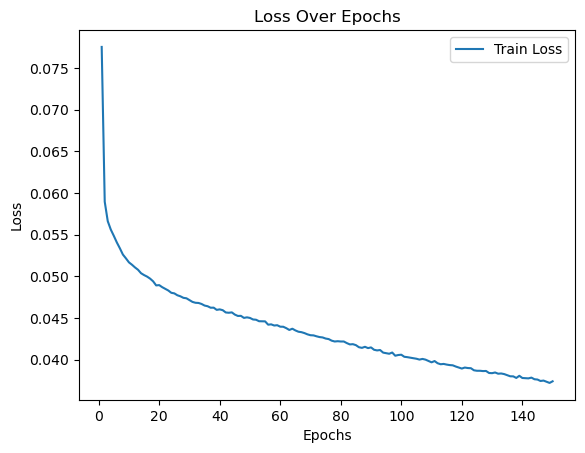

In [22]:
import matplotlib.pyplot as plt
import torch

def accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum().item()
    return correct / y_true.shape[0]

# To store loss values for each epoch
epoch_losses = []

epochs = 150
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy(labels, outputs)

    # Average loss and accuracy for each epoch
    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    epoch_losses.append(epoch_loss)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Plotting the loss over epochs
plt.figure()
plt.plot(range(1, epochs+1), epoch_losses, label='Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Switch to evaluation mode
model.eval().to(device)
y_true = []
y_pred = []

data_loader = DataLoader(dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

key_ll = zip(seq_index, y_pred, y_true)
dictionary = {}

for (key, p, t) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [p], current_value[1] + [t])

agg_true = []
agg_pred = []
for key, val in dictionary.items():
    true = int(np.sum(val[0]) > 0.)
    pred = int(np.sum(val[1]) > 0.)
    # if true != pred:
    #     print(key, val[0], val[1])
    #     print(true, pred)
    agg_true.append(true)
    agg_pred.append(pred)

# model_state_path = "lstm_model_state.pth"
# torch.save(model.state_dict(), model_state_path)

# Calculate metrics
Confusion_Matrix = confusion_matrix(agg_true, agg_pred)
Accuracy = accuracy_score(agg_true, agg_pred)
Precision = precision_score(agg_true, agg_pred, average='binary')
Recall = recall_score(agg_true, agg_pred, average='binary')
F1_Score = f1_score(agg_true, agg_pred, average='binary')

print("Confusion Matrix")
print(Confusion_Matrix)
print("Accuracy: ", Accuracy)
print("Precision: ", Precision)
print("Recall: ", Recall)
print("F1Score: ", F1_Score)

Confusion Matrix
[[20752   357]
 [  751  4497]]
Accuracy:  0.9579618317714459
Precision:  0.9264524103831892
Recall:  0.8568978658536586
F1Score:  0.8903187487626213
